2 MULTI-CLASSIFICATION avec Softmax

PREPARATION DES DONNEES:

/home/henri/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1074, 10)
(1074,)


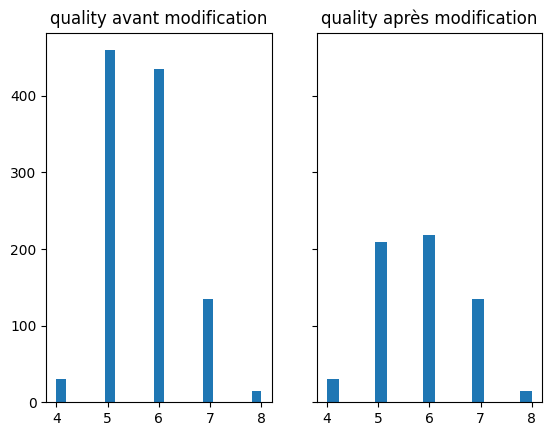

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
df = pd.read_csv('WineQT.csv')
import numpy as np
import matplotlib.pyplot as plt

def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

#On normalise : mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)


normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
#plot_hists(df)

standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
#plot_hists(df)

import numpy as np
import matplotlib.pyplot as plt

#Préparation des données
y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)


#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 2)
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)


METHODE : Nous allons cette fois utiliser une descente de gradient, mais à la place de trouver des coefficients d'une régression linéaire prédisant une valeur de qualité continue, nous allons trouver les coefficients de 9 fonctions pour chaque valeur de qualité ( entre 0 et 8 ). Ces fonctions donnent pour une observation une probabilité d'appartenir à cette qualité. Une prédiction d'une observation X est donc la probabilité maximale d'appartenance à une classe de qualité. L'erreur correspond à la proportion d'observations X mal classées.

CODE :

In [42]:
import copy
import math

def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """

    g = 1/(1+np.exp(-z))
   
    return g
    
def compute_cost_softmax(X, y, W, B):
    m, n = X.shape
    #print("n",n)
    nb_f=W.shape[0]
    #print("nf",nb_f)
   
    loss_sum = 0 

    
  # on calcule tous les zj=fwb
   # Loop over each training example
    for i in range(m): 
      f_WB=np.zeros(nb_f)
      # Loop over each class
      for loop in range(nb_f):
        z_wb = 0 
       # Loop over each feature
        for j in range(n): 

             z_wb_ij = W[loop,j]*X[i,j]
             z_wb += z_wb_ij 
        z_wb += B[loop] 

        f_WB[loop] = np.exp(z_wb)#=e(Zij), #à diviser par sumezi pour avoir probabilité que y==loop
      sumEzi=np.sum(f_WB)
      #print(sumEzi)
      loss_sum += np.log(f_WB[y[i]]/sumEzi) # on ajoute log(a_i) if y=i
      
    total_cost = -(1 / m) * loss_sum  #cost = -1/m(sum(sum{y==j}log(ezj/sum(ezk))))

    return total_cost


def compute_gradient_softmax(X, y, W, B): 


    m, n = X.shape
    nb_f=W.shape[0]

    dJ_DW = np.zeros((nb_f,n))                           #(n,)
    dJ_DB = np.zeros((nb_f))

    for i in range(m): 
      f_WB=np.zeros(nb_f)
      # Loop over each class
      for loop in range(nb_f):
        z_wb = 0 
       # Loop over each feature
        for j in range(n): 

             z_wb_ij = W[loop,j]*X[i,j]
             z_wb += z_wb_ij 
        z_wb += B[loop] 
        f_WB[loop] = np.exp(z_wb)#=e(Zij)

      sumEzi=np.sum(f_WB) 
      f_WB=f_WB/sumEzi # tableau des probabilité que y==loop

      #print("somme des f_WB : ",sum(f_WB))
      #on calcule la dérivé
      for loop in range(nb_f):
        err_loop  = f_WB[loop]  - (loop==y[i])         #scalar, proba que y = loop  - (1 ou 0)(si y ==loop)
        for j in range(n):
            dJ_DW[loop,j] = dJ_DW[loop,j] + err_loop * X[i,j]      #scalar
        #print("dJ_DW[loop,j]",dJ_DW[loop,j])
        dJ_DB[loop] = dJ_DB[loop] + err_loop
    dJ_DW = dJ_DW/m                                   #(n,)
    dJ_DB = dJ_DB/m                                   #scalar
        
    return dJ_DB, dJ_DW 

def gradient_descent_softmax(X, y, W_in, B_in, alpha, num_iters): 

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    W = copy.deepcopy(W_in)  #avoid modifying global w within function
    B = B_in
    m, n = X.shape
    nb_f=W.shape[0]
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dJ_DB, dJ_DW = compute_gradient_softmax(X, y, W, B)   

        # Update Parameters using w, b, alpha and gradient
        W = W - alpha * dJ_DW               
        B = B - alpha * dJ_DB               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_softmax(X, y, W, B) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 5) == 0:
            
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
            
    return W, B, J_history         #return final w,b and J history for graphing 

APPLICATION :

Choix de l'hyperparametre alpha entre alpha = {0.01;0.1;1}
On va utiliser pour cela la cross validation en entraîant sur X_train et en testant sur X_cv

In [43]:
nbClasses=9
np.random.seed(1)
initial_W = np.random.rand(nbClasses,X_train.shape[1]) - 0.5
initial_B = np.ones(nbClasses)*0.5

# Gradient descent settings
iterations = 1000
alpha1 = 0.01 ; alpha2=0.1 ; alpha3=1

W,B, J_history = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha1, iterations)
W2,B2, J_history2 = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha2, iterations)
W3,B3, J_history3 = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha3, iterations)

print("W_alpha1 = ",W, " B_alpha1 = ",B)
print("W_alpha2 = ",W2, " B_alpha2 = ",B2)
print("W_alpha3 = ",W3, " B_alpha3 = ",B3)

Iteration    0: Cost 3.1443088540994824   
Iteration  200: Cost 1.3223472497414896   
Iteration  400: Cost 1.29823940121728   
Iteration  600: Cost 1.279311585627913   
Iteration  800: Cost 1.2633577938613385   
Iteration    0: Cost 2.225247824388585   
Iteration  200: Cost 1.1994820534689488   
Iteration  400: Cost 1.147482084101223   
Iteration  600: Cost 1.1209691041472316   
Iteration  800: Cost 1.1050734627826262   
Iteration    0: Cost 4.941225185729022   
Iteration  200: Cost 9.17072779537021   
Iteration  400: Cost 11.161707528548545   
Iteration  600: Cost 8.5663276066102   
Iteration  800: Cost 8.393041334648622   
W_alpha1 =  [[-0.11163247  0.20549396 -0.50405812 -0.19771849 -0.31077309 -0.44679241
  -0.36810467 -0.17051287 -0.15651844  0.05414941]
 [-0.18060057  0.13363465 -0.31088544  0.36559674 -0.32628283  0.02356858
  -0.28203405  0.00291552 -0.54442089 -0.24779178]
 [ 0.28130074  0.45856514 -0.18984079  0.19030976  0.40369106  0.36663601
  -0.45267508 -0.47151244 -0.36

In [44]:
def locateMax(tab):
    max=0
    for loop in range(len(tab)):
        if tab[loop]>tab[max]:
            max=loop
    return max

In [51]:
def predict_accuracy(X,y,W,B):
    yp = np.zeros(len(X))
    for loop in range(len(X)):
        tabProbas=np.dot(W,X[loop])+B
        tabProbas=sigmoid(tabProbas)
        tabProbas=tabProbas/np.sum(tabProbas)
        yp[loop]=locateMax(tabProbas)
    
    sum=0
    for loop in range(len(yp)):
        if(yp[loop] == y[loop]):
            sum+=1
    print('Train Accuracy (%) : ',(sum/len(yp))*100)
    

In [52]:
print("predictions sur le jeu d'entrainemnt")
predict_accuracy(X_train,y_train,W,B)
predict_accuracy(X_train,y_train,W2,B2)
predict_accuracy(X_train,y_train,W3,B3)

print("predictions sur le jeu cv")
predict_accuracy(X_cv,y_cv,W,B)
predict_accuracy(X_cv,y_cv,W2,B2)
predict_accuracy(X_cv,y_cv,W3,B3)

print("predictions sur le jeu de test")
predict_accuracy(X_test,y_test,W,B)
predict_accuracy(X_test,y_test,W2,B2)
predict_accuracy(X_test,y_test,W3,B3)

predictions sur le jeu d'entrainemnt
Train Accuracy (%) :  48.35164835164835
Train Accuracy (%) :  55.769230769230774
Train Accuracy (%) :  35.16483516483517
predictions sur le jeu cv
Train Accuracy (%) :  49.586776859504134
Train Accuracy (%) :  50.413223140495866
Train Accuracy (%) :  41.32231404958678
predictions sur le jeu de test
Train Accuracy (%) :  49.18032786885246
Train Accuracy (%) :  49.18032786885246
Train Accuracy (%) :  40.98360655737705


On ne prédit parfaitement la note que pour 49% des observations pour notre meilleur alpha.
Calculons l'erreur du modèle sur la note.  

In [53]:
def compute_cost(X,y,W,B):
    m=len(X)
    yp = np.zeros(m)
    for loop in range(m):
        tabProbas=np.dot(W,X[loop])+B
        tabProbas=sigmoid(tabProbas)
        tabProbas=tabProbas/np.sum(tabProbas)
        yp[loop]=locateMax(tabProbas)
    
    cost = 0.0
    for i in range(m):                                
        cost = cost + (y[i] - yp[i])**2        #scalar
    cost = cost / (2 * len(X))                 #scalar    
    return cost


In [56]:
compute_cost(X_test, y_test, W, B)

0.3483606557377049

Le côut est plus élevé que pour la Regression linéaire. Un problème avec la méthode softmax est qu'elle ne fait que de la multi-classification. Pour la qualité du vin, l'importance de l'erreur sur la note doit être prise en compte. C'est le cas dans la regression polynômiale mais pas dans le Softmax (il faudrait changer la méthode de calcul du cout et du gradient). 

Visualisation du résultat sur le jeu de test

In [58]:
x_test = X_test[50]  
print(x_test)

tabProbas=np.dot(W,x_test)+B
tabProbas=sigmoid(tabProbas)
tabProbas=tabProbas/np.sum(tabProbas)
print(np.sum(tabProbas))
print(tabProbas)

print("largest value", np.max(tabProbas), "smallest value", np.min(tabProbas))
print("position du max : ",locateMax(tabProbas))
print("valeur réelle: ",y_test[50])


[ 1.74046617  0.89608802  0.23        0.09531018 -2.41911891  2.89037176
  3.52636052  0.9962      3.21       -1.38629436]
1.0
[0.01886567 0.04138494 0.01752345 0.0150036  0.17839946 0.19323648
 0.19272179 0.18862756 0.15423706]
largest value 0.19323647919778866 smallest value 0.015003596778588256
position du max :  5
valeur réelle:  6


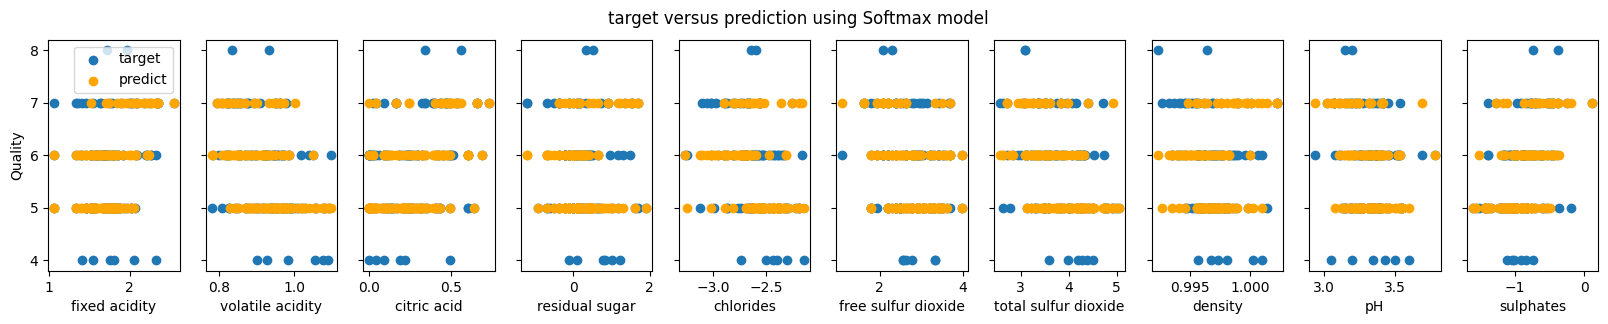

[7. 5. 6. 5. 5. 7. 5. 5. 5. 6. 5. 5. 6. 5. 7. 6. 5. 7. 7. 5. 5. 6. 5. 5.
 5. 6. 5. 7. 6. 5. 5. 7. 7. 6. 7. 7. 5. 5. 5. 5. 5. 5. 6. 6. 6. 6. 5. 7.
 5. 6. 5. 5. 6. 5. 5. 7. 6. 5. 6. 5. 5. 7. 5. 5. 5. 6. 5. 6. 5. 5. 7. 6.
 6. 6. 6. 6. 5. 5. 5. 6. 6. 6. 6. 6. 5. 5. 6. 6. 5. 6. 5. 7. 5. 5. 5. 5.
 7. 5. 7. 6. 6. 6. 5. 6. 5. 6. 5. 6. 5. 6. 7. 5. 5. 5. 5. 7. 6. 7. 5. 5.
 6. 7.]
[6 5 7 5 5 8 6 5 4 6 5 5 6 5 5 5 5 7 6 5 6 5 5 6 6 6 7 7 7 6 5 7 6 6 7 4 5
 6 6 5 4 5 6 5 6 7 5 6 5 8 6 6 6 6 4 7 5 5 7 5 4 7 5 5 7 7 5 6 5 6 7 7 6 6
 7 6 6 6 5 6 6 5 5 6 5 4 6 5 5 6 5 6 5 5 6 6 6 6 6 7 7 6 7 5 6 7 5 5 6 5 7
 5 6 5 5 7 5 7 6 6 6 6]


In [57]:
#predict target using normalized features
m = X_test.shape[0]
yp = np.zeros(m)
for loop in range(len(X_test)):
    tabProbas=np.dot(W,X_test[loop])+B
    tabProbas=sigmoid(tabProbas)
    tabProbas=tabProbas/np.sum(tabProbas)
    yp[loop]=locateMax(tabProbas)

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,nb_feature,figsize=(20, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter([X_test[:,i]],y_test, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter([X_test[:,i]],yp,color="orange", label = 'predict')
ax[0].set_ylabel("Quality"); ax[0].legend()
fig.suptitle("target versus prediction using Softmax model")
plt.show()
print(yp)
print(y_test)


On a aussi du mal a prédire les notes hautes et basses.
Pour avoir une autre approche que la régression ou la multiclassification, nous allons utiliser un réseau de Neurones. Le réseau de neurones va calculer comme pour Softmax une probabilité d'appartenance à une qualité en fonction de l'observation X, mais après plusieurs couches de transformation des données. 